## Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import time
from sklearn.metrics import mean_squared_error,roc_auc_score,mean_absolute_error,log_loss
import sys
sys.path.append('benchmark/')
from gammli_test import gammli
from xgb_test import xgb
from svd_test import svd
from deepfm_fm_test import deepfm_fm
from rank_test import rtest
sys.path.append('../')
from gammli.GAMMLI import GAMMLI
from gammli.DataReader import data_initialize
from gammli.utils import local_visualize
from gammli.utils import global_visualize_density
from gammli.utils import feature_importance_visualize
from gammli.utils import plot_trajectory
from gammli.utils import plot_regularization

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
random_state = 0
data= pd.read_csv('data/simulation/simulation_regression.csv')
task_type = "Regression"

meta_info = OrderedDict()

meta_info['uf_1']={'type': 'continues','source':'user'}
meta_info['uf_2']={'type': 'continues','source':'user'}
meta_info['uf_3']={'type': 'continues','source':'user'}
meta_info['uf_4']={'type': 'continues','source':'user'}
meta_info['uf_5']={'type': 'continues','source':'user'}
meta_info['if_1']={'type': 'continues','source':'item'}
meta_info['if_2']={'type': 'continues','source':'item'}
meta_info['if_3']={'type': 'continues','source':'item'}
meta_info['if_4']={'type': 'continues','source':'item'}
meta_info['if_5']={'type': 'continues','source':'item'}
meta_info['user_id']={"type":"id",'source':'user'}
meta_info['item_id']={"type":"id",'source':'item'}
meta_info['target']={"type":"target",'source':''}
#the best shrinkage is 0.917120
#the best combination is 0.600000
lx_params = {
        "rank":3,
        "main_effect_epochs":2000,
        "interaction_epochs" : 200 ,
        "tuning_epochs" : 50 , 
        "mf_training_iters": 300,
        "u_group_num":50,
        "i_group_num":50,
        "auto_tune":True,
        "best_shrinkage":1,
        "best_combination":0.4,
        "verbose":False
    }

deepfm_fm_params = {
        "epochs":2000,
        "loss_type" : 'mse' ,
        "eval_metric" : mean_absolute_error , 
        "greater_is_better": False,
        "verbose":True,
        "early_stopping":True
    }



W0804 16:26:39.631547  5996 deprecation.py:323] From C:\Users\64161\Anaconda3\lib\site-packages\tensorflow_core\python\compat\v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
result_gammli = gammli('warm',data, meta_info,task_type , random_state=0, params=lx_params)
result_svd = svd('warm',data, meta_info, task_type , random_state=0)
result_deepfm, result_fm = deepfm_fm('warm',data, meta_info,task_type , random_state=0, params=deepfm_fm_params)
result_xgb = xgb('warm',data, meta_info, task_type , random_state=0)

result_sim_std = pd.concat([result_gammli,result_svd,result_xgb,result_deepfm,result_fm],0)

result_sim_std.to_csv('/result/simulation_regression_result.csv',index=None)

## explanation

In [2]:
train , test = train_test_split(data,test_size=0.2 ,random_state=0)
task_type = "Regression"

meta_info = OrderedDict()

meta_info['uf_1']={'type': 'continues','source':'user'}
meta_info['uf_2']={'type': 'continues','source':'user'}
meta_info['uf_3']={'type': 'continues','source':'user'}
meta_info['uf_4']={'type': 'continues','source':'user'}
meta_info['uf_5']={'type': 'continues','source':'user'}
meta_info['if_1']={'type': 'continues','source':'item'}
meta_info['if_2']={'type': 'continues','source':'item'}
meta_info['if_3']={'type': 'continues','source':'item'}
meta_info['if_4']={'type': 'continues','source':'item'}
meta_info['if_5']={'type': 'continues','source':'item'}
meta_info['user_id']={"type":"id",'source':'user'}
meta_info['item_id']={"type":"id",'source':'item'}
meta_info['target']={"type":"target",'source':''}
tr_x, tr_Xi, tr_y, tr_idx, te_x, te_Xi, te_y, val_x, val_Xi, val_y, val_idx, meta_info, model_info,sy,sy_t = data_initialize(train,test,meta_info,task_type ,'warm', random_state, True)
model = GAMMLI(wc='warm',model_info=model_info, meta_info=meta_info, subnet_arch=[20, 10],interact_arch=[20, 10],activation_func=tf.tanh, batch_size=min(500, int(0.2*tr_x.shape[0])), lr_bp=0.001, auto_tune=False,
               interaction_epochs=300,main_effect_epochs=1000,tuning_epochs=100,loss_threshold_main=0.01,loss_threshold_inter=0.5,combine_range=0.98,
              verbose=True, early_stop_thres=200,interact_num=10,u_group_num=30,i_group_num=50,scale_ratio=0.9,n_power_iterations=5,n_oversamples=0,
              mf_training_iters=500,change_mode=True,convergence_threshold=0.001,max_rank=3,interaction_restrict='intra')
model.fit(tr_x, val_x, tr_y, val_y, tr_Xi, val_Xi, tr_idx, val_idx)

..\gammli\DataReader.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype(np.float16)


Memory usage of dataframe is 0.86 MB
Memory usage after optimization is: 0.26 MB
Decreased by 69.6%
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.07 MB
Decreased by 69.6%
test cold start user: 0
test cold start item: 3
validation cold start user: 0
validation cold start item: 1
ListWrapper(['uf_1', 'uf_2', 'uf_3', 'uf_4', 'uf_5', 'if_1', 'if_2', 'if_3', 'if_4', 'if_5'])
####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.41159, val loss: 0.41502
Main effects training epoch: 2, train loss: 0.39143, val loss: 0.39571
Main effects training epoch: 3, train loss: 0.36986, val loss: 0.37540
Main effects training epoch: 4, train loss: 0.34836, val loss: 0.35464
Main effects training epoch: 5, train loss: 0.32606, val loss: 0.33272
Main effects training epoch: 6, train loss: 0.30484, val loss: 0.31195
Main effects training epoch: 7, train loss: 0.2890

Main effects training epoch: 110, train loss: 0.10382, val loss: 0.10518
Main effects training epoch: 111, train loss: 0.10391, val loss: 0.10556
Main effects training epoch: 112, train loss: 0.10380, val loss: 0.10556
Main effects training epoch: 113, train loss: 0.10389, val loss: 0.10543
Main effects training epoch: 114, train loss: 0.10380, val loss: 0.10534
Main effects training epoch: 115, train loss: 0.10381, val loss: 0.10550
Main effects training epoch: 116, train loss: 0.10391, val loss: 0.10572
Main effects training epoch: 117, train loss: 0.10388, val loss: 0.10526
Main effects training epoch: 118, train loss: 0.10381, val loss: 0.10551
Main effects training epoch: 119, train loss: 0.10382, val loss: 0.10558
Main effects training epoch: 120, train loss: 0.10379, val loss: 0.10546
Main effects training epoch: 121, train loss: 0.10384, val loss: 0.10545
Main effects training epoch: 122, train loss: 0.10385, val loss: 0.10543
Main effects training epoch: 123, train loss: 0.103

Main effects training epoch: 227, train loss: 0.10373, val loss: 0.10547
Main effects training epoch: 228, train loss: 0.10374, val loss: 0.10552
Main effects training epoch: 229, train loss: 0.10373, val loss: 0.10578
Main effects training epoch: 230, train loss: 0.10371, val loss: 0.10536
Main effects training epoch: 231, train loss: 0.10375, val loss: 0.10574
Main effects training epoch: 232, train loss: 0.10374, val loss: 0.10540
Main effects training epoch: 233, train loss: 0.10371, val loss: 0.10564
Main effects training epoch: 234, train loss: 0.10370, val loss: 0.10541
Main effects training epoch: 235, train loss: 0.10369, val loss: 0.10542
Main effects training epoch: 236, train loss: 0.10370, val loss: 0.10547
Main effects training epoch: 237, train loss: 0.10370, val loss: 0.10562
Main effects training epoch: 238, train loss: 0.10370, val loss: 0.10549
Main effects training epoch: 239, train loss: 0.10374, val loss: 0.10569
Main effects training epoch: 240, train loss: 0.103

Main effects tuning epoch: 55, train loss: 0.10380, val loss: 0.10518
Main effects tuning epoch: 56, train loss: 0.10380, val loss: 0.10516
Main effects tuning epoch: 57, train loss: 0.10389, val loss: 0.10537
Main effects tuning epoch: 58, train loss: 0.10384, val loss: 0.10508
Main effects tuning epoch: 59, train loss: 0.10381, val loss: 0.10517
Main effects tuning epoch: 60, train loss: 0.10380, val loss: 0.10508
Main effects tuning epoch: 61, train loss: 0.10383, val loss: 0.10538
Main effects tuning epoch: 62, train loss: 0.10380, val loss: 0.10512
Main effects tuning epoch: 63, train loss: 0.10380, val loss: 0.10496
Main effects tuning epoch: 64, train loss: 0.10387, val loss: 0.10539
Main effects tuning epoch: 65, train loss: 0.10380, val loss: 0.10517
Main effects tuning epoch: 66, train loss: 0.10382, val loss: 0.10508
Main effects tuning epoch: 67, train loss: 0.10387, val loss: 0.10545
Main effects tuning epoch: 68, train loss: 0.10382, val loss: 0.10509
Main effects tuning 

Interaction training epoch: 73, train loss: 0.03434, val loss: 0.03476
Interaction training epoch: 74, train loss: 0.03460, val loss: 0.03528
Interaction training epoch: 75, train loss: 0.03462, val loss: 0.03506
Interaction training epoch: 76, train loss: 0.03348, val loss: 0.03400
Interaction training epoch: 77, train loss: 0.03531, val loss: 0.03554
Interaction training epoch: 78, train loss: 0.03417, val loss: 0.03455
Interaction training epoch: 79, train loss: 0.03464, val loss: 0.03471
Interaction training epoch: 80, train loss: 0.03401, val loss: 0.03408
Interaction training epoch: 81, train loss: 0.03397, val loss: 0.03446
Interaction training epoch: 82, train loss: 0.03347, val loss: 0.03382
Interaction training epoch: 83, train loss: 0.03359, val loss: 0.03420
Interaction training epoch: 84, train loss: 0.03500, val loss: 0.03540
Interaction training epoch: 85, train loss: 0.03393, val loss: 0.03447
Interaction training epoch: 86, train loss: 0.03352, val loss: 0.03387
Intera

Interaction training epoch: 188, train loss: 0.03402, val loss: 0.03434
Interaction training epoch: 189, train loss: 0.03253, val loss: 0.03279
Interaction training epoch: 190, train loss: 0.03205, val loss: 0.03259
Interaction training epoch: 191, train loss: 0.03346, val loss: 0.03372
Interaction training epoch: 192, train loss: 0.03323, val loss: 0.03364
Interaction training epoch: 193, train loss: 0.03279, val loss: 0.03312
Interaction training epoch: 194, train loss: 0.03262, val loss: 0.03305
Interaction training epoch: 195, train loss: 0.03334, val loss: 0.03350
Interaction training epoch: 196, train loss: 0.03250, val loss: 0.03302
Interaction training epoch: 197, train loss: 0.03200, val loss: 0.03256
Interaction training epoch: 198, train loss: 0.03447, val loss: 0.03494
Interaction training epoch: 199, train loss: 0.03236, val loss: 0.03278
Interaction training epoch: 200, train loss: 0.03251, val loss: 0.03265
Interaction training epoch: 201, train loss: 0.03226, val loss: 

Interaction tuning epoch: 3, train loss: 0.03220, val loss: 0.03245
Interaction tuning epoch: 4, train loss: 0.03242, val loss: 0.03272
Interaction tuning epoch: 5, train loss: 0.03358, val loss: 0.03371
Interaction tuning epoch: 6, train loss: 0.03218, val loss: 0.03244
Interaction tuning epoch: 7, train loss: 0.03218, val loss: 0.03261
Interaction tuning epoch: 8, train loss: 0.03471, val loss: 0.03450
Interaction tuning epoch: 9, train loss: 0.03313, val loss: 0.03318
Interaction tuning epoch: 10, train loss: 0.03328, val loss: 0.03332
Interaction tuning epoch: 11, train loss: 0.03353, val loss: 0.03382
Interaction tuning epoch: 12, train loss: 0.03387, val loss: 0.03386
Interaction tuning epoch: 13, train loss: 0.03302, val loss: 0.03321
Interaction tuning epoch: 14, train loss: 0.03275, val loss: 0.03319
Interaction tuning epoch: 15, train loss: 0.03183, val loss: 0.03227
Interaction tuning epoch: 16, train loss: 0.03330, val loss: 0.03346
Interaction tuning epoch: 17, train loss:

C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\64161\Anaconda3\lib\site-packages\numpy\core\_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[SoftImpute] Iter 1: observed MAE=0.027411 validation MAE=0.031198,rank=3
[SoftImpute] Iter 2: observed MAE=0.026212 validation MAE=0.030567,rank=3
[SoftImpute] Iter 3: observed MAE=0.025202 validation MAE=0.029936,rank=3
[SoftImpute] Iter 4: observed MAE=0.024299 validation MAE=0.029360,rank=3
[SoftImpute] Iter 5: observed MAE=0.023498 validation MAE=0.028824,rank=3
[SoftImpute] Iter 6: observed MAE=0.022798 validation MAE=0.028328,rank=3
[SoftImpute] Iter 7: observed MAE=0.022165 validation MAE=0.027889,rank=3
[SoftImpute] Iter 8: observed MAE=0.021643 validation MAE=0.027504,rank=3
[SoftImpute] Iter 9: observed MAE=0.021180 validation MAE=0.027132,rank=3
[SoftImpute] Iter 10: observed MAE=0.020822 validation MAE=0.026825,rank=3
[SoftImpute] Iter 11: observed MAE=0.020497 validation MAE=0.026526,rank=3
[SoftImpute] Iter 12: observed MAE=0.020228 validation MAE=0.026262,rank=3
[SoftImpute] Iter 13: observed MAE=0.019914 validation MAE=0.025924,rank=3
[SoftImpute] Iter 14: observed MAE

[SoftImpute] Iter 111: observed MAE=0.015021 validation MAE=0.020768,rank=3
[SoftImpute] Iter 112: observed MAE=0.015019 validation MAE=0.020797,rank=3
[SoftImpute] Iter 113: observed MAE=0.015034 validation MAE=0.020826,rank=3
[SoftImpute] Iter 114: observed MAE=0.014998 validation MAE=0.020769,rank=3
[SoftImpute] Iter 115: observed MAE=0.014994 validation MAE=0.020790,rank=3
[SoftImpute] Iter 116: observed MAE=0.014980 validation MAE=0.020774,rank=3
[SoftImpute] Iter 117: observed MAE=0.014954 validation MAE=0.020760,rank=3
[SoftImpute] Iter 118: observed MAE=0.014923 validation MAE=0.020722,rank=3
[SoftImpute] Iter 119: observed MAE=0.014962 validation MAE=0.020759,rank=3
[SoftImpute] Iter 120: observed MAE=0.014936 validation MAE=0.020744,rank=3
[SoftImpute] Iter 121: observed MAE=0.014903 validation MAE=0.020739,rank=3
[SoftImpute] Iter 122: observed MAE=0.014920 validation MAE=0.020730,rank=3
[SoftImpute] Iter 123: observed MAE=0.014903 validation MAE=0.020707,rank=3
[SoftImpute]

[SoftImpute] Iter 221: observed MAE=0.014544 validation MAE=0.020468,rank=3
[SoftImpute] Iter 222: observed MAE=0.014513 validation MAE=0.020437,rank=3
[SoftImpute] Iter 223: observed MAE=0.014524 validation MAE=0.020434,rank=3
[SoftImpute] Iter 224: observed MAE=0.014522 validation MAE=0.020452,rank=3
[SoftImpute] Iter 225: observed MAE=0.014542 validation MAE=0.020460,rank=3
[SoftImpute] Iter 226: observed MAE=0.014476 validation MAE=0.020428,rank=3
[SoftImpute] Iter 227: observed MAE=0.014527 validation MAE=0.020444,rank=3
[SoftImpute] Iter 228: observed MAE=0.014530 validation MAE=0.020469,rank=3
[SoftImpute] Iter 229: observed MAE=0.014501 validation MAE=0.020439,rank=3
[SoftImpute] Iter 230: observed MAE=0.014537 validation MAE=0.020464,rank=3
[SoftImpute] Iter 231: observed MAE=0.014517 validation MAE=0.020456,rank=3
[SoftImpute] Iter 232: observed MAE=0.014503 validation MAE=0.020432,rank=3
[SoftImpute] Iter 233: observed MAE=0.014540 validation MAE=0.020459,rank=3
[SoftImpute]

In [7]:
pred = model.predict(te_x, te_Xi)
mae = mean_absolute_error(te_y,pred)
rmse = mean_squared_error(te_y,pred)**0.5
print(mae,rmse)

0.030290884685865757 0.053512724494281724


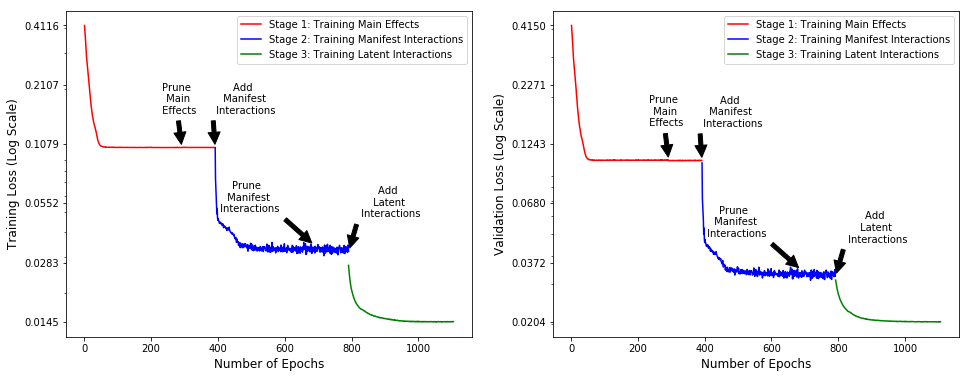

In [3]:
simu_dir = 'result'
data_dict_logs = model.final_gam_model.summary_logs(save_dict=False)
data_dict_logs.update({"err_train_mf":model.final_mf_model.mf_mae,
                       "err_val_mf":model.final_mf_model.mf_valmae})
plot_trajectory(data_dict_logs, folder=simu_dir, name="s1_traj_plot", log_scale=True, save_png=False, save_eps=True)
#plot_regularization(data_dict_logs, folder=simu_dir, name="s1_regu_plot", log_scale=True, save_png=False, save_eps=False)

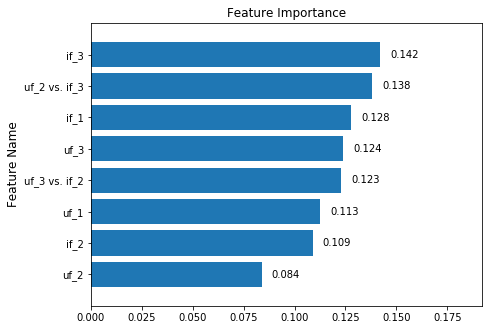

In [4]:
data_dict = model.final_gam_model.global_explain(0,save_dict=False,threshold=0.03)
feature_importance_visualize(data_dict, save_eps=True, folder=simu_dir, name='s1_feature')

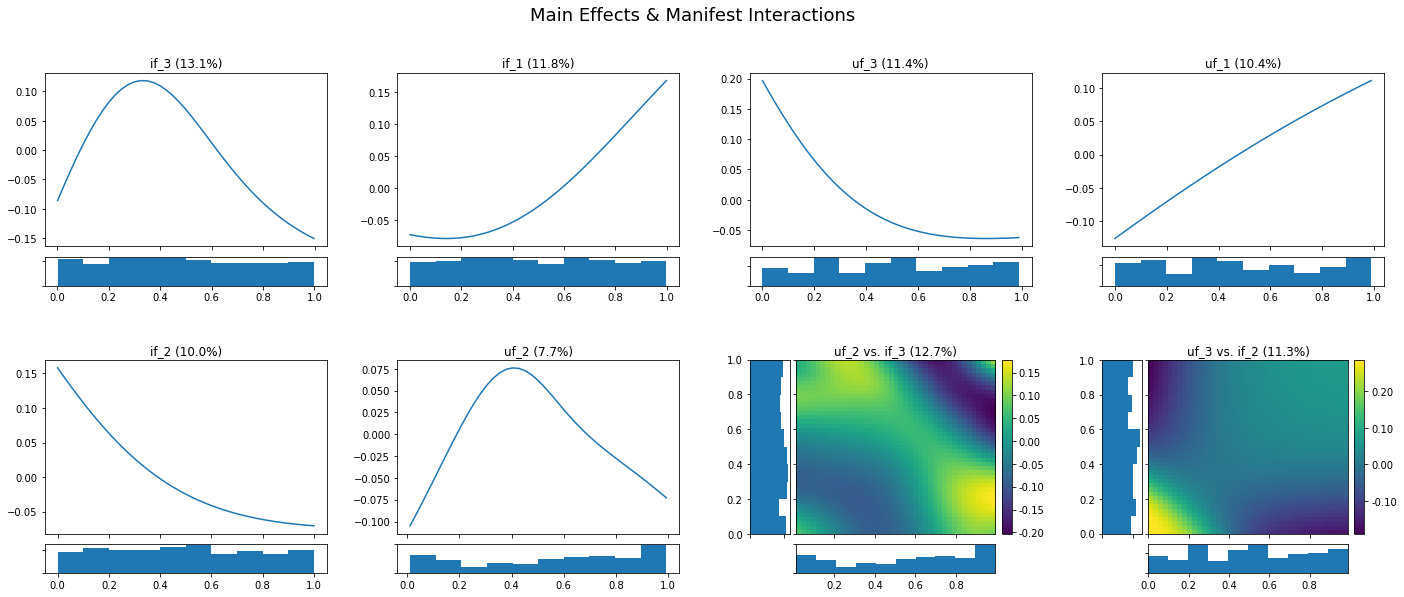

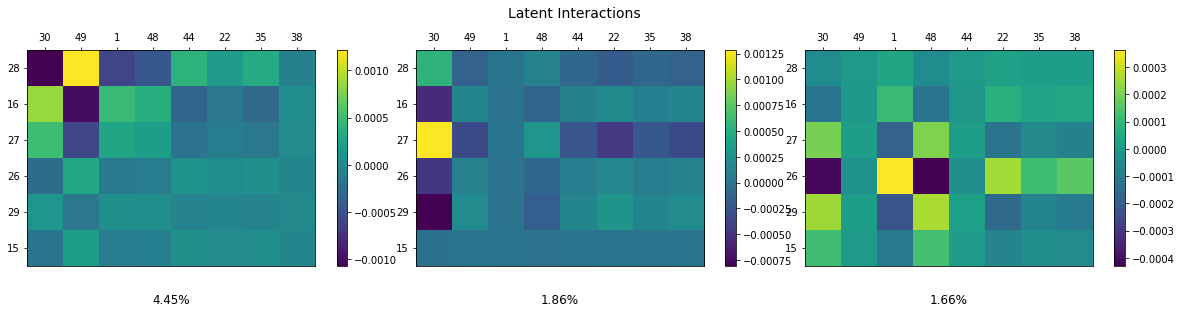

In [5]:
importance = model.get_all_rank(tr_Xi)
model.dash_board(data_dict, importance,simu_dir,True)

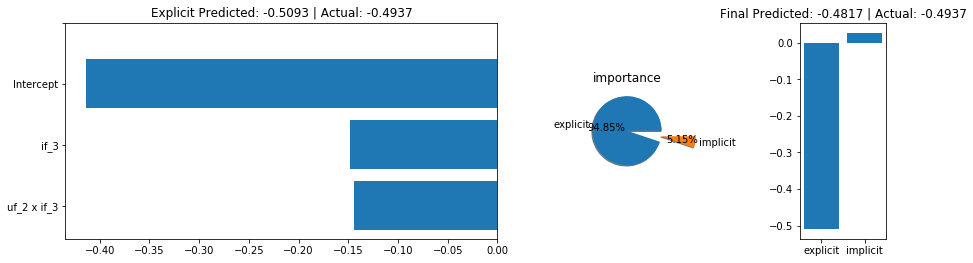

In [8]:
data_dict_local = model.local_explain(0,55,tr_x,tr_Xi,tr_y)
local_visualize(data_dict_local, save_eps=True, folder=simu_dir, name='s1_local',task_type="Regression")

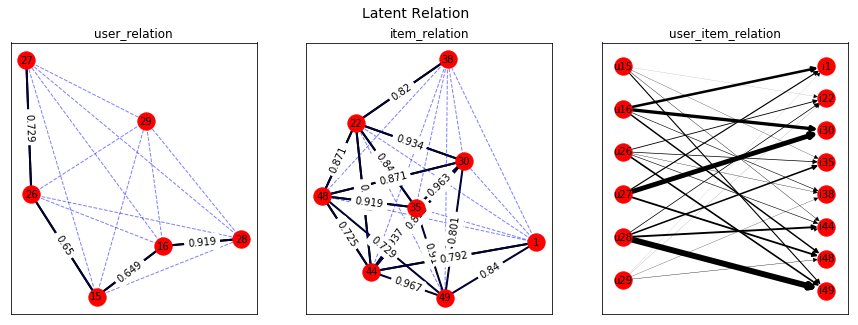

In [6]:
model.relation_plot(0.6,500,True)

In [9]:
new = te_x[100,:].reshape(1,-1)
_ = model.cold_start_analysis(new,'user',1.96)

The new user belong to group 28
 mean is [-0.074282   -0.03589288  0.00775704]
 and std is [0.03657689 0.04036326 0.0253481 ]
 the confidence interval is [[-0.1459727  -0.11500487 -0.04192524],[-0.00259131  0.04321911  0.05743932]]


## real image

In [16]:
def uf23(x):
    x1,x2 = x
    y = 0.5 * np.exp(-4*(x1+x2)+4)
    return y

def if23(x):
    x1,x2 = x
    y = np.sin(2*np.pi*x1*x2)
    return y

data_dict['uf_1']['outputs']=data_dict['uf_1']['inputs']*5-np.mean(data_dict['uf_1']['inputs']*5)
data_dict['uf_2']['outputs']=uf23(np.meshgrid(data_dict['uf_2']['inputs'], data_dict['uf_3']['inputs'])).mean(0)-uf23(np.meshgrid(data_dict['uf_2']['inputs'], data_dict['uf_3']['inputs'])).mean(0).mean()
data_dict['uf_3']['outputs']=uf23(np.meshgrid(data_dict['uf_2']['inputs'], data_dict['uf_3']['inputs'])).mean(1)-uf23(np.meshgrid(data_dict['uf_2']['inputs'], data_dict['uf_3']['inputs'])).mean(1).mean()

data_dict['if_1']['outputs']=data_dict['if_1']['inputs']**2*5-np.mean(data_dict['uf_1']['inputs']**2*5)
data_dict['if_2']['outputs']=if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean(0)-if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean(0).mean()
data_dict['if_3']['outputs']=if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean(1)-if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean(1).mean()

data_dict['uf_2 vs. if_3']['outputs']= np.flip(uf23(np.meshgrid(data_dict['uf_2 vs. if_3']['input1'], data_dict['uf_2 vs. if_3']['input2']))- \
                                        uf23(np.meshgrid(data_dict['uf_2 vs. if_3']['input1'], data_dict['uf_2 vs. if_3']['input2'])).mean(0)- \
                                        uf23(np.meshgrid(data_dict['uf_2 vs. if_3']['input1'], data_dict['uf_2 vs. if_3']['input2'])).mean(1).reshape([-1,1])+ \
                                        uf23(np.meshgrid(data_dict['uf_2 vs. if_3']['input1'], data_dict['uf_2 vs. if_3']['input2'])).mean(),axis=0)

data_dict['uf_3 vs. if_2']['outputs']= np.flip((if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs']))- \
                                        if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean(0)- \
                                        if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean(1).reshape([-1,1])+ \
                                        if23(np.meshgrid(data_dict['if_2']['inputs'], data_dict['if_3']['inputs'])).mean()),axis=0)

In [32]:
interaction_norm = [model.final_gam_model.interact_blocks.interacts[i].moving_norm.numpy()[0] for i in range(model.final_gam_model.interact_num_added)]

In [3]:
from itertools import product
result = {}
name_i = {}
imp = model.final_mf_model.s
impp = imp/ imp.sum()
una = np.array(list(model.match_u.keys()))
for i in range(3):
    u1=np.array(list(model.match_u.values()))[:,i]
    i1=np.array(list(model.match_i.values()))[:,i]
    

    ina = np.array(list(model.match_i.keys()))
    
    res = []
    for a,b in product(u1, i1):
        res.append(a*b)
    res = np.array(res).reshape(u1.shape[0],-1)
    
    modd = []
    for j in range(res.shape[1]):
        modd.append(np.linalg.norm(res[:,j]))
    res = res[:,np.argsort(modd)[::-1]]
    ina = ina[np.argsort(modd)[::-1]]
    name_i[i]=ina
    result[i]=res

In [8]:
data1 = result[0]
from sklearn.cluster import SpectralBiclustering
from sklearn.metrics import consensus_score
n_clusters = (4, 10)
rng = np.random.RandomState(0)
row_idx = rng.permutation(data1.shape[0])
col_idx = rng.permutation(data1.shape[1])
data1 = data1[row_idx][:, col_idx]
bimodel = SpectralBiclustering(n_clusters=n_clusters, method='log',
                             random_state=0)
bimodel.fit(data1)
score = consensus_score(bimodel.biclusters_,
                        (rows[:, row_idx], columns[:, col_idx]))

print("consensus score: {:.1f}".format(score))

fit_data = data1[np.argsort(bimodel.row_labels_)]
fit_data = fit_data[:, np.argsort(bimodel.column_labels_)]

NameError: name 'rows' is not defined

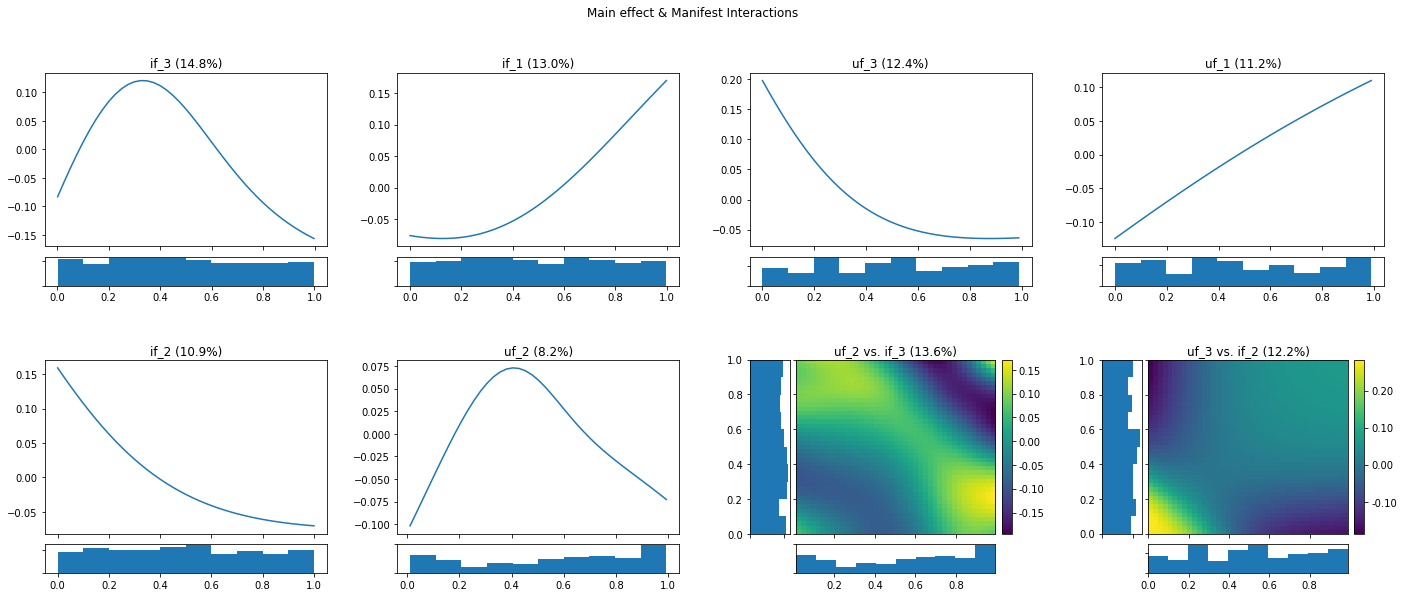

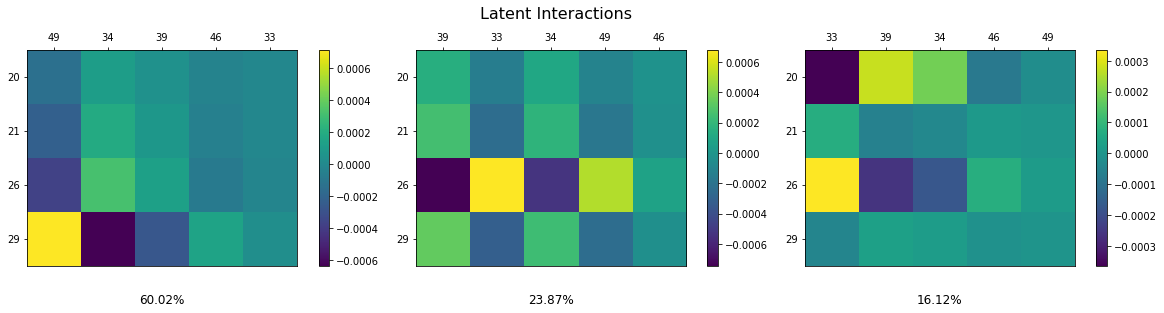

In [17]:
global_visualize_density(data_dict, save_png=False,save_eps=False, folder=simu_dir, name='s1_global')
from matplotlib import pyplot as plt
left_x,left_y=0.5,0.1
width,height=0.8,0.5
left_xh=left_x+width+0.1
left_xhh=left_xh+width+0.1
#left_yh = left_y + height + 0.1

scatter_area=[left_x,left_y,1,height]
hist_y=[left_xh,left_y,1,height]
hist_yy = [left_xhh,left_y,1,height]
#hist_g = [left_xh,left_yh,1,height]

plt.figure(figsize=(6, round(14 * 0.45)))
plt.suptitle('Latent Interactions',fontsize=16,x=1.9,y=0.7)

area_1=plt.axes(scatter_area)
area_2=plt.axes(hist_y)
area_3=plt.axes(hist_yy)

ax1 = area_1.matshow(result[0])
area_1.xaxis.set_ticks_position('top') #设置x轴刻度到上方
area_1.set_xticks(np.arange(result[0].shape[1])) #设置x轴刻度
area_1.set_yticks(np.arange(result[0].shape[0])) #设置y轴刻度
area_1.set_xticklabels(name_i[0]) #设置x轴刻度标签
area_1.set_yticklabels(una) #设置y轴刻度标签
#plt.colorbar(area_scatter,pad=0.03) #设置颜色条
area_1.set_title("%.2f%%" % (impp[0][0] * 100),y=-0.2) #设置标题以及其位置和字体大小 

ax2 = area_2.matshow(result[1])
area_2.xaxis.set_ticks_position('top') #设置x轴刻度到上方
area_2.set_xticks(np.arange(result[1].shape[1])) #设置x轴刻度
area_2.set_yticks(np.arange(result[1].shape[0])) #设置y轴刻度
area_2.set_xticklabels(name_i[1]) #设置x轴刻度标签
area_2.set_yticklabels(una) #设置y轴刻度标签
area_2.set_title("%.2f%%" % (impp[1][1] * 100),y=-0.2) #设置标题以及其位置和字体大小 

ax3 = area_3.matshow(result[2])
area_3.xaxis.set_ticks_position('top') #设置x轴刻度到上方
area_3.set_xticks(np.arange(result[2].shape[1])) #设置x轴刻度
area_3.set_yticks(np.arange(result[2].shape[0])) #设置y轴刻度
area_3.set_xticklabels(name_i[2]) #设置x轴刻度标签
area_3.set_yticklabels(una) #设置y轴刻度标签
#plt.colorbar(area_scatter,pad=0.03) #设置颜色条
area_3.set_title("%.2f%%" % (impp[2][2] * 100),y=-0.2) 
plt.colorbar(ax1,ax=area_1)
plt.colorbar(ax2,ax=area_2)
plt.colorbar(ax3,ax=area_3)

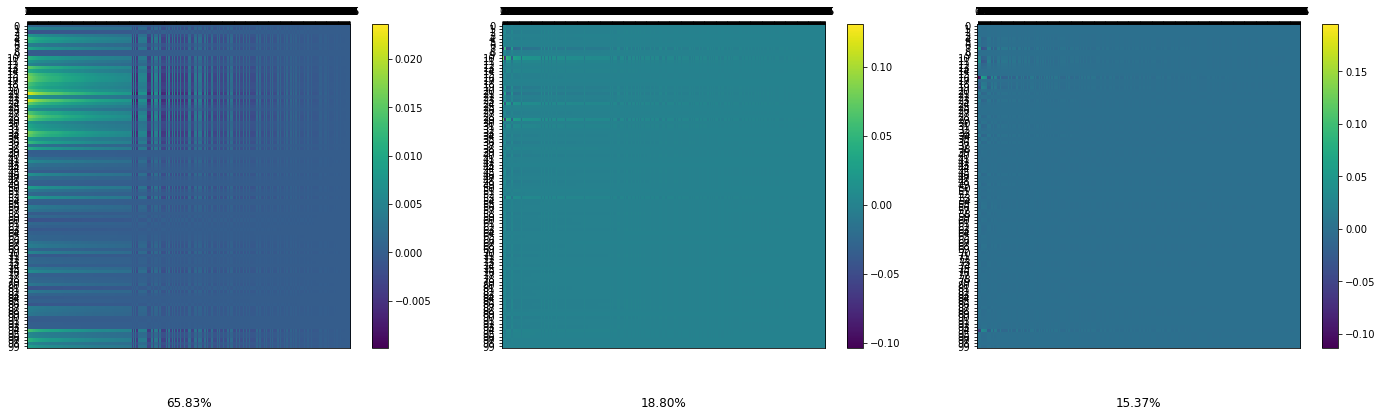

In [9]:
from matplotlib import pyplot as plt

left_x,left_y=0.1,0.1
width,height=1,0.5
left_xh=left_x+width+0.1
left_xhh=left_xh+width+0.1

scatter_area=[left_x,left_y,1,height]
hist_y=[left_xh,left_y,1,height]
hist_yy = [left_xhh,left_y,1,height]

plt.figure(figsize=(6, round(20 * 0.45)))

area_1=plt.axes(scatter_area)
area_2=plt.axes(hist_y)
area_3=plt.axes(hist_yy)

ax1 = area_1.imshow(result[0])
area_1.set_aspect(10)
area_1.xaxis.set_ticks_position('top') #设置x轴刻度到上方
area_1.set_xticks(np.arange(result[0].shape[1])) #设置x轴刻度
area_1.set_yticks(np.arange(result[0].shape[0])) #设置y轴刻度
area_1.set_xticklabels(range(result[0].shape[1])) #设置x轴刻度标签
area_1.set_yticklabels(range(result[0].shape[0])) #设置y轴刻度标签
#plt.colorbar(area_scatter,pad=0.03) #设置颜色条
area_1.set_title("%.2f%%" % (impp[0][0] * 100),y=-0.2) #设置标题以及其位置和字体大小 

ax2 = area_2.imshow(result[1])
area_2.set_aspect(10)
area_2.xaxis.set_ticks_position('top') #设置x轴刻度到上方
area_2.set_xticks(np.arange(result[1].shape[1])) #设置x轴刻度
area_2.set_yticks(np.arange(result[1].shape[0])) #设置y轴刻度
area_2.set_xticklabels(range(result[0].shape[1])) #设置x轴刻度标签
area_2.set_yticklabels(range(result[0].shape[0])) #设置y轴刻度标签
#plt.colorbar(area_scatter,pad=0.03) #设置颜色条
area_2.set_title("%.2f%%" % (impp[1][1] * 100),y=-0.2) #设置标题以及其位置和字体大小 

ax3 = area_3.imshow(result[2])
area_3.set_aspect(10)
area_3.xaxis.set_ticks_position('top') #设置x轴刻度到上方
area_3.set_xticks(np.arange(result[2].shape[1])) #设置x轴刻度
area_3.set_yticks(np.arange(result[2].shape[0])) #设置y轴刻度
area_3.set_xticklabels(range(result[0].shape[1])) #设置x轴刻度标签
area_3.set_yticklabels(range(result[0].shape[0])) #设置y轴刻度标签
#plt.colorbar(area_scatter,pad=0.03) #设置颜色条
area_3.set_title("%.2f%%" % (impp[2][2] * 100),y=-0.2) #设置标题以及其位置和字体大小 
plt.colorbar(ax1,ax=area_1)
plt.colorbar(ax2,ax=area_2)
plt.colorbar(ax3,ax=area_3)